# TimeSeries - a new object for handling time domain data

### NOTE: Internet access is required in order to use this tutorial

TimeSeries is a new feature in the SunPy 0.8 release, replacing the LightCurve object which is now deprecated. Similar to LightCurve, TimeSeries handles time domain data from a variety of solar instruments, including every mission that was previously supported by LightCurve. In TimeSeries, the downloading of data has been separated from the object - now, the object operates only on data files, while downloading is done via other tools such as the Unified Downloader (FIDO).

In this notebook, we demonstrate how to use TimeSeries and give a brief tour of its features.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime
import sunpy
from sunpy.net import Fido, attrs as a

### 1. Download a data file to work with
As mentioned above, TimeSeries does not download data itself. That functionality is covered by other SunPy tools. Without going into detail, here we use Fido to download a GOES XRS data file from 2011 June 7. Detailed tutorials on using FIDO may be found elsewhere.

In [2]:
search_results = Fido.search(a.Time('2011-06-07 00:00','2011-06-07 08:00'),a.Instrument('XRS'))
Fido.fetch(search_results[0],path='.')

[                                        ]========================================


['./go1520110607.2.fits']

### 2. Create a TimeSeries object from a data file

Now that we have a GOES data file in the local directory, let's load it into a TimeSeries object and take a look at it.

/Users/ainglis/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


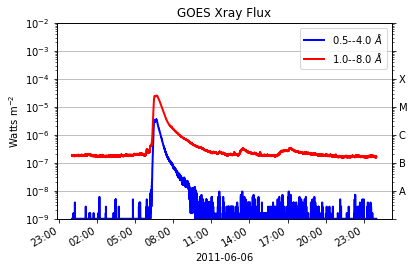

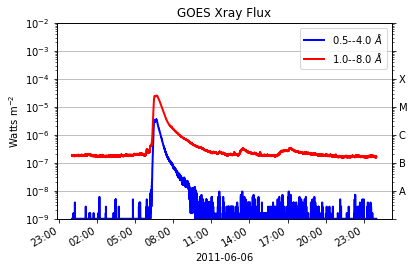

In [3]:
from sunpy import timeseries
goes = timeseries.TimeSeries('go1520110607.fits')
goes.peek()

Here we can see a quicklook plot of the data in the object. It shows the two GOES XRS channels, 0.5-4A and 1-8A. We can see that a solar flare occured at ~06:20 UT.

The TimeSeries object retains the metadata from the originating file. We can query this as follows:

In [4]:
print(goes.meta)

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2011-06-06 23:59:59.961999 | xrsa            | simple: True                                      |
|            to             | xrsb            | bitpix: 8                                         |
|2011-06-07 23:59:57.631999 |                 | naxis: 0                                          |
|                           |                 | extend: True                                      |
|                           |                 | date: 26/06/2012                                  |
|                           |                 | numext: 3                                         |
|                           |                 | telescop: GOES 15                                 |


The data itself is stored in something called a pandas DataFrame. This DataFrame is designed to hold column-based data. The first column is the index (i.e. the time dimension), while the other columns correspond to the dependent variables, in this case the flux from the two GOES channels. Below, we show what the data looks like, showing only the first 5 rows for brevity.

In [5]:
print(goes.data[0:5])

                                    xrsa          xrsb
2011-06-06 23:59:59.961999  1.000000e-09  1.887100e-07
2011-06-07 00:00:02.008999  1.000000e-09  1.834600e-07
2011-06-07 00:00:04.058999  1.000000e-09  1.860900e-07
2011-06-07 00:00:06.104999  1.000000e-09  1.808400e-07
2011-06-07 00:00:08.151999  1.000000e-09  1.860900e-07


Data for a particular variable can easily be extracted like this (again, extracting only the first 5 rows for convenience):

In [6]:
xrsa = goes.data['xrsa'][0:5]
print(xrsa)

2011-06-06 23:59:59.961999    1.000000e-09
2011-06-07 00:00:02.008999    1.000000e-09
2011-06-07 00:00:04.058999    1.000000e-09
2011-06-07 00:00:06.104999    1.000000e-09
2011-06-07 00:00:08.151999    1.000000e-09
Name: xrsa, dtype: float32


The TimeSeries object also knows the units of the data in each column, e.g.

In [7]:
print(goes.units)

OrderedDict([('xrsa', Unit("W / m2")), ('xrsb', Unit("W / m2"))])


### 3. Working with TimeSeries objects

By default, the entire file contents are converted to a TimeSeries object. A subset of the data can easily be extracted, similar to creating a SubMap from a larger Map object. This is done using the ```truncate()``` function:

/Users/ainglis/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


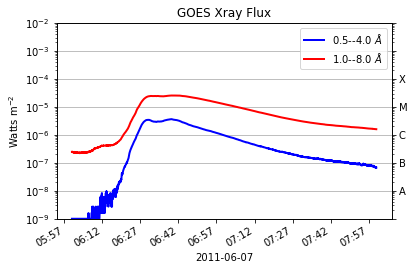

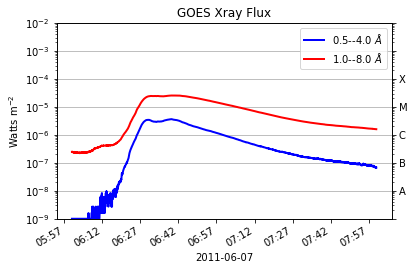

In [8]:
goes2 = goes.truncate('2011-06-07 06:00','2011-06-07 08:00')
goes2.peek()

#### Finding the maxima in the data
We can easily find the maximum value for each channel, and the index location of these maxima, like so:

In [9]:
print(goes2.data.max())
print(goes2.data.idxmax())

xrsa    0.000004
xrsb    0.000026
dtype: float32
xrsa   2011-06-07 06:39:00.761999
xrsb   2011-06-07 06:41:24.118999
dtype: datetime64[ns]


#### Subtracting the moving average of the data
The TimeSeries object contains a number of useful tools for common time series operations. For example, to subtract a rolling mean of the data, we can use the built-in function ```rolling()```

In [10]:
smoothed_goes_data = goes2.data.rolling(60, center=True).mean()

The object `smoothed_goes_data` contains the rolling mean with a 60-point window for each channel. We can easily subtract it from the original data and plot the result.

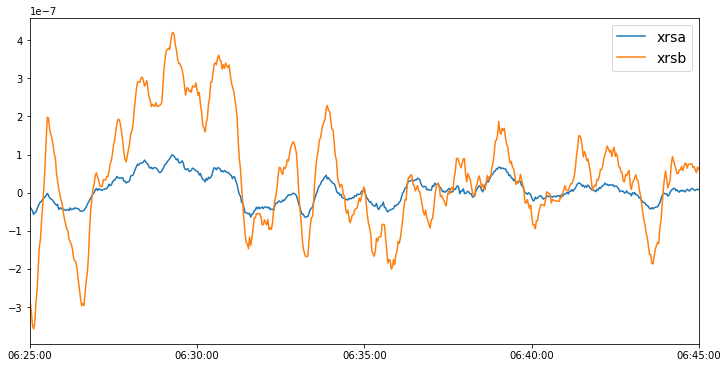

In [12]:
fig1 = plt.figure(1,figsize=(12,6))
plt.plot(goes2.data.index,goes2.data['xrsa'] - smoothed_goes_data['xrsa'],label='xrsa')
plt.plot(goes2.data.index,goes2.data['xrsb'] - smoothed_goes_data['xrsb'],label='xrsb')
plt.xlim(datetime.datetime(2011,6,7,6,25),datetime.datetime(2011,6,7,6,45))
plt.legend(fontsize=14)

#This line just formats the x-axis to look nicer
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


#### Resample the TimeSeries
It is easy to resample the data in the TimeSeries, for example to reduce the cadence:

In [51]:
goes_resampled = goes2.data.resample('30S').mean()

In [54]:
print(goes_resampled[0:5])

                             xrsa          xrsb
2011-06-07 06:00:00  1.000000e-09  2.447357e-07
2011-06-07 06:00:30  1.000000e-09  2.399513e-07
2011-06-07 06:01:00  1.000000e-09  2.379893e-07
2011-06-07 06:01:30  1.000000e-09  2.340040e-07
2011-06-07 06:02:00  1.000000e-09  2.268373e-07


#### Other useful functions

In [ ]:
goes2.data.diff() # take the difference between each data point
goes2.data.cumsum() # return the cumulative sum of the data.
goes2.index.duplicated() # returns True for time indexes that appear more than once in the TimeSeries
goes2.index.drop_duplicates() # just remove all duplicate rows from the TimeSeries
goes2.concatenate() # allows two DataFrames to be joined together into one.

...and much more!

### 4. Summary
By the end of this notebook you should have some familarity with the basic functionality of TimeSeries, including:
  - how to create a TimeSeries from a data file
  - how to access the data and metadata in the TimeSeries object
  - how to create a truncated TimeSeries from a longer one
  - how to perform simple data manipulation, such as averaging, subtracting a running mean.